In [1]:
import os
import random
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from glob import glob
import tqdm
import tqdm.notebook 

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf

from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers import concatenate, add
from keras.layers import MaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img

In [2]:
im_width = 128
im_height = 128
border = 5


In [3]:
train_files = []
mask_files = glob('Dataset\\LGG_Segmentation\\**\*_mask*', recursive = True)

for i in mask_files:
    train_files.append(i.replace('_mask',''))


In [4]:
print("No. of images = ", len(train_files))
print("No. of masks = ", len(mask_files))


No. of images =  3929
No. of masks =  3929


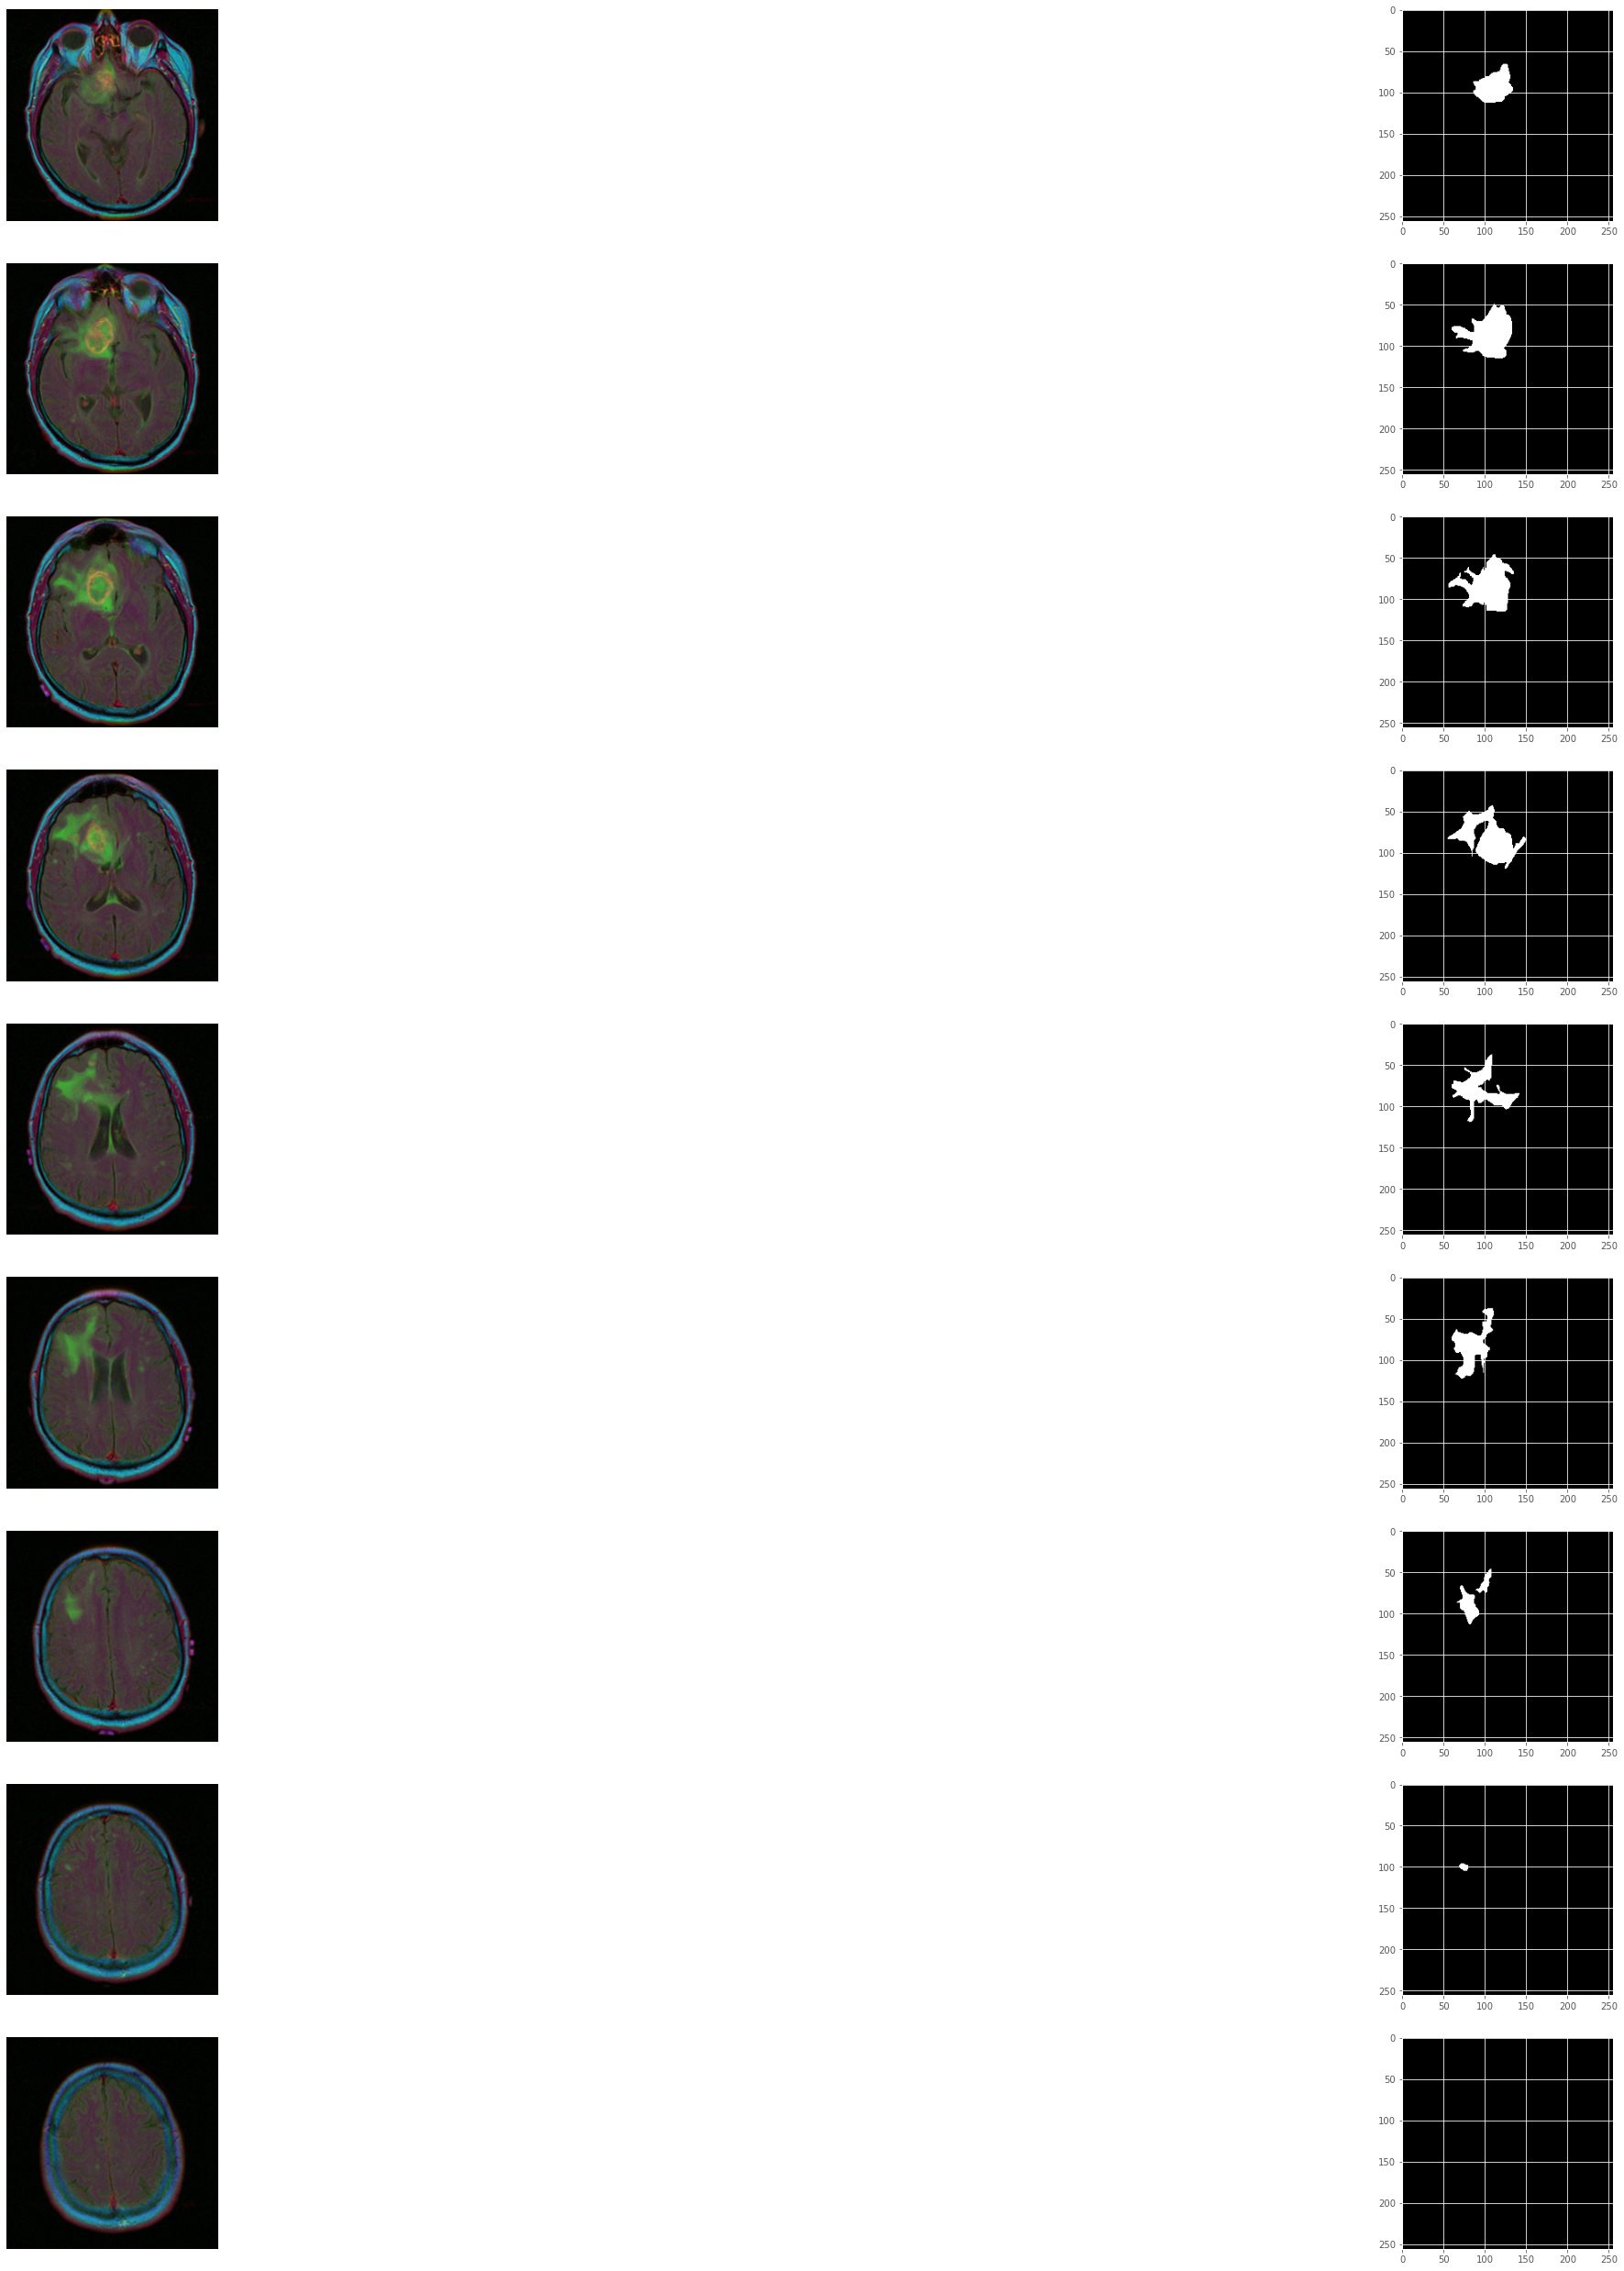

In [5]:
rows = 10
columns = 2
fig = plt.figure(figsize=(50, 50))

for i in range(1,10):
    fig.add_subplot(rows, columns, 2*i-1)
    img = cv.imread(train_files[i])
    mask = cv.imread(mask_files[i])
    plt.axis('off')
    plt.imshow(img)
    fig.add_subplot(rows, columns, 2*i)
    plt.imshow(mask)

plt.show()


In [6]:
X = np.zeros((len(train_files), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(train_files), im_height, im_width, 1), dtype=np.float32)


In [7]:
train_files[1]

'Dataset\\LGG_Segmentation\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif'

In [8]:
import tqdm
import tqdm.notebook 

for n, file in tqdm.notebook.tqdm(enumerate(train_files), total=len(train_files)):
    # Load images
    img = load_img(train_files[n])
    x_img = np.array(img)
    x_img = resize(x_img, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Load masks
    mask = np.array(load_img(mask_files[n]))
    mask = resize(mask, (128, 128, 1), mode = 'constant', preserve_range = True)
    # Save images
    X[n] = x_img/255.0
    y[n] = mask/255.0


  0%|          | 0/3929 [00:00<?, ?it/s]

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=42)


In [10]:
from keras.layers import MaxPool2D, UpSampling2D, Concatenate

def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
 
    return x

def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
 
    out = Activation("relu")(Wg + Ws)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
 
    return out * s

def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation="bilinear")(x)
    s = attention_gate(x, s, num_filters)
    x = Concatenate()([x, s])
    x = conv_block(x, num_filters)
    return x

def attention_unet(input_shape):

    inputs = Input(input_shape)
 
    #Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
 
    b1 = conv_block(p3, 512)
 
    #Decoder
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
     
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d3)
 
    model = Model(inputs, outputs, name="Attention-UNET")
    return model

In [11]:
input_shape = (128, 128, 1)
model = attention_unet(input_shape)
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

In [12]:
model.summary()

Model: "Attention-UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                    

                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 32, 32, 256)  0          ['batch_normalization_8[0][0]',  
 da)                                                              'batch_normalization_9[0][0]']  
                                                                                                  
 activation_8 (Activation)      (None, 32, 32, 256)  0           ['tf.__operators__.add[0][0]']   
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 32, 256)  65792       ['activation_8[0][0]']           
                                                                                                  
 activation_9 (Activation)      (None, 32, 32, 256)  0           ['conv2d_10[0][0]']              
                                                                                                  
 tf.math.m

 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 tf.__operators__.add_2 (TFOpLa  (None, 128, 128, 64  0          ['batch_normalization_16[0][0]', 
 mbda)                          )                                 'batch_normalization_17[0][0]'] 
                                                                                                  
 activation_16 (Activation)     (None, 128, 128, 64  0           ['tf.__operators__.add_2[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 128, 128, 64  4160        ['activation_16[0][0]']          
          

In [24]:
callbacks = [
    EarlyStopping(patience=2, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-mri.h5', verbose=1, save_best_only=True, save_weights_only=True)
]


In [ ]:
#results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
#                    validation_data=(X_valid, y_valid))



Epoch 1/50
 3/86 [>.............................] - ETA: 59:52 - loss: 0.0112 - accuracy: 0.9887  

NameError: name 'results' is not defined

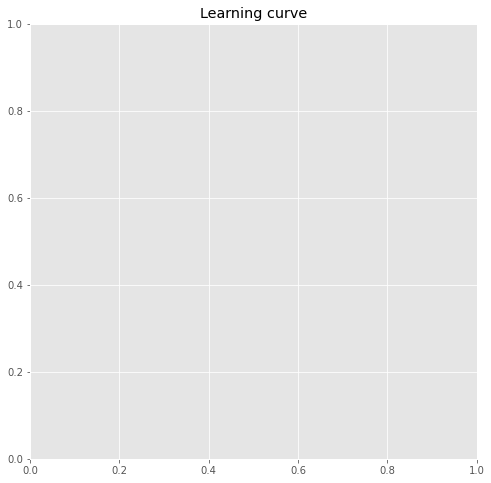

In [64]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();


In [13]:
model.load_weights('model-mri.h5')
#model.evaluate(X, y, verbose=1)

In [19]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0
    fig, ax = plt.subplots(1, 3, figsize=(20, 10))
    #ax[0].imshow(X[ix, ..., 0])
    if has_mask:
        ax[0].imshow(y[ix].squeeze())
    ax[0].set_title('tumour')

    ax[1].imshow(binary_preds[ix].squeeze())
    ax[1].set_title('pred tumour')
    
    ax[2].imshow(X[ix])
    ax[2].set_title('image')

In [17]:
print(X[0:1].shape)
preds_val = model.predict(X[0:1], verbose=1)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

(1, 128, 128, 1)
1/1 [==============================] - 0s 473ms/step


In [22]:
for i in range(10):
    plot_sample(X[0:1], y[0:1], preds_val, preds_val_t, ix=i)

IndexError: index 1 is out of bounds for axis 0 with size 1

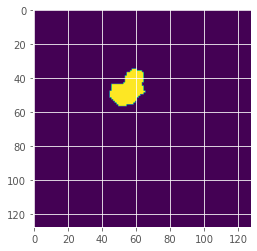

<Figure size 432x288 with 0 Axes>

In [45]:
tumour_image = preds_val_t[1]
#cv.imwrite('tumour_image.png', tumour_image)
plt.imshow(tumour_image)
plt.show()
plt.savefig('tumour_image.png')
